In [ ]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as Models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score
from tqdm import tqdm

In [ ]:
RandomState = 2022484
np.random.seed(RandomState)
random.seed(RandomState)
torch.manual_seed(RandomState)
Device = torch.device("cuda")

In [ ]:
def LoadMetaFromDirectory(DataDir):
    MetaData = []
    for MajorCategory in os.listdir(DataDir):
        MajorPath = os.path.join(DataDir, MajorCategory)
        if os.path.isdir(MajorPath):
            for ClassName in os.listdir(MajorPath):
                ClassPath = os.path.join(MajorPath, ClassName)
                if os.path.isdir(ClassPath):
                    for FileName in os.listdir(ClassPath):
                        if FileName.endswith(".wav"):
                            MetaData.append({
                                "filename": FileName,
                                "major_category": MajorCategory,
                                "class_name": ClassName,
                                "file_path": os.path.join(ClassPath, FileName)
                            })
    return pd.DataFrame(MetaData)

In [ ]:
def PlotClassDistribution(MetaDf):
    plt.figure(figsize=(12, 5))
    sns.countplot(data=MetaDf, x="class_name", order=MetaDf["class_name"].value_counts().index)
    plt.title("Class Distribution in ESC-50")
    plt.xticks(rotation=90)
    plt.xlabel("Class Name")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
def PlotMajorCategoryDistribution(MetaDf):
    plt.figure(figsize=(7, 5))
    sns.countplot(data=MetaDf, x="major_category")
    plt.title("Major Category Distribution in ESC-50")
    plt.xticks(rotation=45)
    plt.xlabel("Major Category")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
def DisplayRandomAudios(MetaDf, NumSamples=6):
    RandomFiles = MetaDf.sample(NumSamples, random_state=RandomState)
    Fig, Axes = plt.subplots(2, NumSamples, figsize=(22, 8))
    
    for i, (_, Row) in enumerate(RandomFiles.iterrows()):
        FilePath = Row["file_path"]
        FileName = Row["filename"]
        ClassName = Row["class_name"]
        MajorCategory = Row["major_category"]

        Signal, Sr = librosa.load(FilePath, sr=None)
        MelSpec = librosa.feature.melspectrogram(
            y=Signal, sr=Sr, n_fft=2048, hop_length=512, n_mels=128
        )
        MelSpecDb = librosa.power_to_db(MelSpec, ref=np.max)

        Axes[0, i].plot(np.linspace(0, len(Signal) / Sr, len(Signal)), Signal, color="b")
        Axes[0, i].set_title(f"{FileName}\n{ClassName} ({MajorCategory})", fontsize=9)
        Axes[0, i].axis("tight")

        Img = librosa.display.specshow(
            MelSpecDb, sr=Sr, hop_length=512, x_axis="time", y_axis="mel",
            cmap="viridis", ax=Axes[1, i]
        )
        Axes[1, i].set_title("Mel Spectrogram", fontsize=9)
        if i == NumSamples - 1:
            Fig.colorbar(Img, ax=Axes[1, i], format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

In [ ]:
def SplitTrainValTest(MetaDf, ValRatio=0.1, TestRatio=0.1):
    TrainRatio = 1.0 - (ValRatio + TestRatio)
    TrainDf, TempDf = train_test_split(
        MetaDf,
        test_size=(1 - TrainRatio),
        stratify=MetaDf["class_name"],
        random_state=RandomState
    )
    RelativeValRatio = ValRatio / (ValRatio + TestRatio)
    ValDf, TestDf = train_test_split(
        TempDf,
        test_size=(1 - RelativeValRatio),
        stratify=TempDf["class_name"],
        random_state=RandomState
    )
    return TrainDf, ValDf, TestDf

In [ ]:
def FixedCountSplit(TrainDf, XPerClass):
    LabeledList = []
    UnlabeledList = []
    Grouped = TrainDf.groupby("class_name")
    for Cname, GroupDf in Grouped:
        GroupList = GroupDf.sample(frac=1, random_state=RandomState).values.tolist()
        if len(GroupList) <= XPerClass:
            LabeledList.extend(GroupList)
        else:
            LabeledList.extend(GroupList[:XPerClass])
            UnlabeledList.extend(GroupList[XPerClass:])
    LabeledCols = TrainDf.columns.tolist()
    UnlabeledCols = TrainDf.columns.tolist()

    LabeledDf = pd.DataFrame(LabeledList, columns=LabeledCols)
    UnlabeledDf = pd.DataFrame(UnlabeledList, columns=UnlabeledCols)
    return LabeledDf, UnlabeledDf

In [ ]:
def AddGaussianNoise(Signal, NoiseFactor=0.05):
    Noise = np.random.normal(0, 1, len(Signal))
    return Signal + NoiseFactor * Noise

def PitchChange(Signal, Sr, PitchRange=5):
    PitchSteps = np.random.uniform(-PitchRange, PitchRange)
    return librosa.effects.pitch_shift(Signal, sr=Sr, n_steps=PitchSteps)

def SpecAugment(MelSpec, TimeMaskParam=20, FreqMaskParam=10):
    MelSpecAug = MelSpec.copy()
    if MelSpecAug.shape[1] > TimeMaskParam:
        T0 = np.random.randint(0, MelSpecAug.shape[1] - TimeMaskParam)
        MelSpecAug[:, T0:T0 + TimeMaskParam] = 0
    if MelSpecAug.shape[0] > FreqMaskParam:
        F0 = np.random.randint(0, MelSpecAug.shape[0] - FreqMaskParam)
        MelSpecAug[F0:F0 + FreqMaskParam, :] = 0
    return MelSpecAug

def Cutout(MelSpec, NumHoles=8, HoleSize=(5, 5)):
    MelSpecAug = MelSpec.copy()
    H, W = MelSpec.shape
    for _ in range(NumHoles):
        Y = np.random.randint(0, H - HoleSize[0])
        X = np.random.randint(0, W - HoleSize[1])
        MelSpecAug[Y:Y + HoleSize[0], X:X + HoleSize[1]] = 0
    return MelSpecAug

In [ ]:
def AudioWeakAugmentation(Signal, Sr):
    TransformType = random.choice(["noise", "pitch_shift"])
    if TransformType == "noise":
        Signal = AddGaussianNoise(Signal, NoiseFactor=0.02)
    else:
        Signal = PitchChange(Signal, Sr, PitchRange=2)
    MelSpec = librosa.feature.melspectrogram(
        y=Signal, sr=Sr, n_fft=2048, hop_length=512, n_mels=128
    )
    MelSpecDb = librosa.power_to_db(MelSpec, ref=np.max)
    return MelSpecDb

def AudioStrongAugmentation(Signal, Sr):
    TransformType = random.choice(["big_pitch_shift", "heavy_noise"])
    if TransformType == "big_pitch_shift":
        Signal = PitchChange(Signal, Sr, PitchRange=5)
    else:
        Signal = AddGaussianNoise(Signal, NoiseFactor=0.05)

    MelSpec = librosa.feature.melspectrogram(
        y=Signal, sr=Sr, n_fft=2048, hop_length=512, n_mels=128
    )
    MelSpecDb = librosa.power_to_db(MelSpec, ref=np.max)

    SpecTransform = random.choice(["spec_augment", "cutout"])
    if SpecTransform == "spec_augment":
        MelSpecDb = SpecAugment(MelSpecDb, TimeMaskParam=25, FreqMaskParam=12)
    else:
        MelSpecDb = Cutout(MelSpecDb, NumHoles=10, HoleSize=(5, 5))

    return MelSpecDb

In [ ]:
class AudioReFixMatchDataset(Dataset):
    def __init__(self, Df, IsUnlabeled=False):
        super().__init__()
        self.Df = Df.reset_index(drop=True)
        self.IsUnlabeled = IsUnlabeled
        self.Classes = sorted(Df["class_name"].unique())  
        self.ClassToIdx = {Cname: Idx for Idx, Cname in enumerate(self.Classes)}

    def __len__(self):
        return len(self.Df)

    def __getitem__(self, Idx):
        Row = self.Df.iloc[Idx]
        FilePath = Row["file_path"]
        ClassName = Row["class_name"]
        Label = self.ClassToIdx[ClassName]

        Signal, Sr = librosa.load(FilePath, sr=None)

        MelSpecOrig = librosa.feature.melspectrogram(
            y=Signal, sr=Sr, n_fft=2048, hop_length=512, n_mels=128
        )
        MelSpecOrigDb = librosa.power_to_db(MelSpecOrig, ref=np.max)

        MelSpecWeakDb = AudioWeakAugmentation(Signal, Sr)

        MelSpecStrongDb = AudioStrongAugmentation(Signal, Sr)

        OrigTensor = torch.tensor(MelSpecOrigDb, dtype=torch.float).unsqueeze(0)
        WeakTensor = torch.tensor(MelSpecWeakDb, dtype=torch.float).unsqueeze(0)
        StrongTensor = torch.tensor(MelSpecStrongDb, dtype=torch.float).unsqueeze(0)

        if self.IsUnlabeled:
            return {
                "Original": OrigTensor,
                "Weak": WeakTensor,
                "Strong": StrongTensor,
                "Label": -1
            }
        else:
            return {
                "Original": OrigTensor,
                "Weak": WeakTensor,
                "Strong": StrongTensor,
                "Label": Label
            }


In [ ]:
class AudioTestDataset(Dataset):
    def __init__(self, Df):
        super().__init__()
        self.Df = Df.reset_index(drop=True)
        self.Classes = sorted(Df["class_name"].unique())
        self.ClassToIdx = {Cname: Idx for Idx, Cname in enumerate(self.Classes)}

    def __len__(self):
        return len(self.Df)

    def __getitem__(self, Idx):
        Row = self.Df.iloc[Idx]
        FilePath = Row["file_path"]
        ClassName = Row["class_name"]
        Label = self.ClassToIdx[ClassName]

        Signal, Sr = librosa.load(FilePath, sr=None)
        MelSpec = librosa.feature.melspectrogram(
            y=Signal, sr=Sr, n_fft=2048, hop_length=512, n_mels=128
        )
        MelSpecDb = librosa.power_to_db(MelSpec, ref=np.max)

        MelTensor = torch.tensor(MelSpecDb, dtype=torch.float).unsqueeze(0)
        return MelTensor, Label

In [ ]:
class AudioDenseNet(nn.Module):
    def __init__(self, NumClasses=50):
        super().__init__()
        self.Backbone = Models.densenet121(weights=Models.DenseNet121_Weights.DEFAULT)
        self.Backbone.features.conv0 = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        nn.init.kaiming_normal_(self.Backbone.features.conv0.weight, mode='fan_out', nonlinearity='relu')

        NumFeats = self.Backbone.classifier.in_features
        self.Backbone.classifier = nn.Linear(NumFeats, NumClasses)

    def forward(self, X):
        return self.Backbone(X)

In [ ]:
def TrainReFixMatchAudio(
    Model,
    LabeledLoader,
    UnlabeledLoader,
    ValLoader,
    TestLoader,
    RealClassNames,    
    NumEpochs=20,
    Lr=0.01,
    Tau=0.95,
    LambdaU=0.8,
    Eps=1e-8,
    RunName="Run"
):
    NumClasses = len(RealClassNames)
    Optimizer = torch.optim.SGD(Model.parameters(), lr=Lr, momentum=0.9, weight_decay=1e-4)
    Scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(Optimizer, T_max=NumEpochs)
    Model = Model.to(Device)

    TrainLossList = []
    TrainSupLossList = []
    TrainUnsupLossList = []
    TrainAccList = []
    ValLossList = []
    ValAccList = []

    for Epoch in range(NumEpochs):
        Model.train()
        TotalLoss = 0.0
        SupLossTotal = 0.0
        UnsupLossTotal = 0.0
        CorrectSup = 0
        TotalSup = 0
        BatchCount = 0

        UnlabeledIter = iter(UnlabeledLoader)

        for LabeledBatch in tqdm(LabeledLoader, desc=f"{RunName} - Epoch {Epoch+1}/{NumEpochs}", leave=False):
            InputsLWeak = LabeledBatch["Weak"].float().to(Device)
            LabelsL = LabeledBatch["Label"].to(Device).long()
            LogitsL = Model(InputsLWeak)
            LossSup = F.cross_entropy(LogitsL, LabelsL)

            PredsL = torch.argmax(LogitsL, dim=1)
            CorrectSup += (PredsL == LabelsL).sum().item()
            TotalSup += LabelsL.size(0)

            try:
                UnlabeledBatch = next(UnlabeledIter)
            except StopIteration:
                UnlabeledIter = iter(UnlabeledLoader)
                UnlabeledBatch = next(UnlabeledIter)

            InputsUWeak = UnlabeledBatch["Weak"].float().to(Device)
            InputsUStrong = UnlabeledBatch["Strong"].float().to(Device)

            with torch.no_grad():
                LogitsUWeak = Model(InputsUWeak)
                ProbsUWeak = F.softmax(LogitsUWeak, dim=1)

            MaxProbs, PseudoLabels = torch.max(ProbsUWeak, dim=1)
            Mask = (MaxProbs >= Tau).float()

            LogitsUStrong = Model(InputsUStrong)
            ProbsUStrong = F.softmax(LogitsUStrong, dim=1)
            LossUCe = F.cross_entropy(LogitsUStrong, PseudoLabels, reduction="none")
            LossUCe = (LossUCe * Mask).mean()

            LowConfMask = 1 - Mask
            if LowConfMask.sum() > 0:
                Temp = 0.5
                PWeakSharp = ProbsUWeak ** (1.0 / Temp)
                PWeakSharp = PWeakSharp / (PWeakSharp.sum(dim=1, keepdim=True) + Eps)
                LossUKl = F.kl_div(
                    torch.log(torch.clamp(PWeakSharp, min=Eps)),
                    ProbsUStrong,
                    reduction="batchmean"
                )
            else:
                LossUKl = 0.0

            LossUnsup = LossUCe + (LossUKl if not isinstance(LossUKl, float) else 0.0)
            Loss = LossSup + LambdaU * LossUnsup

            Optimizer.zero_grad()
            Loss.backward()
            torch.nn.utils.clip_grad_norm_(Model.parameters(), max_norm=5.0)
            Optimizer.step()

            TotalLoss += Loss.item()
            SupLossTotal += LossSup.item()
            UnsupLossTotal += LossUnsup.item()
            BatchCount += 1

        AvgLoss = TotalLoss / BatchCount
        AvgSupLoss = SupLossTotal / BatchCount
        AvgUnsupLoss = UnsupLossTotal / BatchCount
        TrainAcc = CorrectSup / TotalSup

        TrainLossList.append(AvgLoss)
        TrainSupLossList.append(AvgSupLoss)
        TrainUnsupLossList.append(AvgUnsupLoss)
        TrainAccList.append(TrainAcc)

        Model.eval()
        ValLossVal = 0.0
        ValBatches = 0
        ValPreds = []
        ValLabelsList = []
        with torch.no_grad():
            for ValInput, ValLabels in ValLoader:
                ValInput = ValInput.float().to(Device)
                ValLabels = ValLabels.to(Device)
                LogitsVal = Model(ValInput)
                LossVal = F.cross_entropy(LogitsVal, ValLabels)
                ValLossVal += LossVal.item()
                ValBatches += 1
                Preds = torch.argmax(LogitsVal, dim=1)
                ValPreds.extend(Preds.cpu().numpy())
                ValLabelsList.extend(ValLabels.cpu().numpy())

        AvgValLoss = ValLossVal / ValBatches
        ValAccuracy = accuracy_score(ValLabelsList, ValPreds)
        ValLossList.append(AvgValLoss)
        ValAccList.append(ValAccuracy)

        print(f"{RunName} [Epoch {Epoch+1}/{NumEpochs}] "
              f"TrainLoss: {AvgLoss:.4f} (Sup={AvgSupLoss:.4f}, Unsup={AvgUnsupLoss:.4f}), "
              f"TrainAcc: {TrainAcc*100:.2f}% | "
              f"ValLoss: {AvgValLoss:.4f}, ValAcc: {ValAccuracy*100:.2f}%")

        Scheduler.step()

    TestPreds = []
    TestLabelsList = []
    TestProbsList = []
    Model.eval()
    with torch.no_grad():
        for TestInput, TestLabels in TestLoader:
            TestInput = TestInput.float().to(Device)
            TestLabels = TestLabels.to(Device)
            LogitsTest = Model(TestInput)
            ProbsTest = F.softmax(LogitsTest, dim=1)
            PredsTest = torch.argmax(LogitsTest, dim=1)

            TestPreds.extend(PredsTest.cpu().numpy())
            TestLabelsList.extend(TestLabels.cpu().numpy())
            TestProbsList.extend(ProbsTest.cpu().numpy())

    TestAcc = accuracy_score(TestLabelsList, TestPreds)
    OneHotTestLabels = np.eye(NumClasses)[np.array(TestLabelsList)]
    RocAuc = roc_auc_score(OneHotTestLabels, np.array(TestProbsList), multi_class="ovr")
    AvgPrecision = average_precision_score(OneHotTestLabels, np.array(TestProbsList), average="macro")

    print(f"\n{RunName} --- Final Test Results ---")
    print(f"Test Accuracy: {TestAcc*100:.2f}%")
    print(f"ROC AUC: {RocAuc:.4f}, Average Precision (AUC-PRC): {AvgPrecision:.4f}")

    print("\nClassification Report:")
    idx_to_class = {i: c for i, c in enumerate(RealClassNames)}
    target_names = [idx_to_class[i] for i in range(NumClasses)]
    print(classification_report(TestLabelsList, TestPreds, target_names=target_names, zero_division=0))

    torch.save(Model.state_dict(), f"ReFixMatch_ESC50_{RunName}.pth")
    print(f"Model weights saved to ReFixMatch_ESC50_{RunName}.pth")

    return {
        "TrainLoss": TrainLossList,
        "TrainSupLoss": TrainSupLossList,
        "TrainUnsupLoss": TrainUnsupLossList,
        "TrainAcc": TrainAccList,
        "ValLoss": ValLossList,
        "ValAcc": ValAccList,
        "TestAcc": TestAcc,
        "RocAuc": RocAuc,
        "AvgPrecision": AvgPrecision
    }

In [ ]:
def Main():
    DataDir = r"X:\Projects\ML\Project\esc_50"
    MetaDf = LoadMetaFromDirectory(DataDir)

    print("\nDataset Overview:")
    print(MetaDf.head())
    print(f"\nTotal number of recordings: {len(MetaDf)}")
    print(f"Unique major categories: {MetaDf['major_category'].nunique()}")
    print(f"Unique classes: {MetaDf['class_name'].nunique()}")

    print("\nPlotting Class Distribution:")
    PlotClassDistribution(MetaDf)

    print("\nPlotting Major Category Distribution:")
    PlotMajorCategoryDistribution(MetaDf)

    print("\nDisplaying Audio Waveforms & Spectrograms Of Random Samples:")
    DisplayRandomAudios(MetaDf, NumSamples=3)

    TrainDf, ValDf, TestDf = SplitTrainValTest(MetaDf, ValRatio=0.1, TestRatio=0.1)

    AllClasses = sorted(MetaDf["class_name"].unique())
    print(f"\nDetected {len(AllClasses)} total unique classes:", AllClasses)
    
    ResultsDict = {}
    LabeledCounts = [5, 9, 17, 26]

    for X in LabeledCounts:
        print(f"\n=== ReFixMatch with {X} labeled samples per class ===")
        LabeledDf, UnlabeledDf = FixedCountSplit(TrainDf, XPerClass=X)

        LabeledDataset = AudioReFixMatchDataset(LabeledDf, IsUnlabeled=False)
        UnlabeledDataset = AudioReFixMatchDataset(UnlabeledDf, IsUnlabeled=True)
        ValDataset = AudioTestDataset(ValDf)
        TestDatasetVar = AudioTestDataset(TestDf)

        BatchSize = 16
        LabeledLoader = DataLoader(LabeledDataset, batch_size=BatchSize, shuffle=True, num_workers=0)
        UnlabeledLoader = DataLoader(UnlabeledDataset, batch_size=BatchSize, shuffle=True, num_workers=0)
        ValLoader = DataLoader(ValDataset, batch_size=BatchSize, shuffle=False, num_workers=0)
        TestLoader = DataLoader(TestDatasetVar, batch_size=BatchSize, shuffle=False, num_workers=0)

        ModelVar = AudioDenseNet(NumClasses=len(AllClasses))

        RunName = f"{X}_PerClass"
        RunResults = TrainReFixMatchAudio(
            Model=ModelVar,
            LabeledLoader=LabeledLoader,
            UnlabeledLoader=UnlabeledLoader,
            ValLoader=ValLoader,
            TestLoader=TestLoader,
            RealClassNames=AllClasses,
            NumEpochs=20,
            Lr=0.01,
            Tau=0.95,
            LambdaU=0.8,
            RunName=RunName
        )

        Epochs = range(1, len(RunResults["TrainLoss"])+1)

        plt.figure(figsize=(8,5))
        plt.plot(Epochs, RunResults["TrainLoss"], label="Total Train Loss", marker="o")
        plt.plot(Epochs, RunResults["TrainSupLoss"], label="Supervised Loss", marker="o")
        plt.plot(Epochs, RunResults["TrainUnsupLoss"], label="Unsupervised Loss", marker="o")
        plt.title(f"Training Loss Curves (FC={X})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(Epochs, RunResults["TrainAcc"], label="Train Accuracy", marker="o")
        plt.title(f"Training Accuracy (FC={X})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(Epochs, RunResults["ValLoss"], label="Validation Loss", marker="o", color="red")
        plt.title(f"Validation Loss (FC={X})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(Epochs, [val*100 for val in RunResults["ValAcc"]], label="Val Accuracy (%)", marker="o", color="green")
        plt.title(f"Validation Accuracy (FC={X})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(Epochs, RunResults["TrainLoss"], label="Train Loss", marker="o")
        plt.plot(Epochs, RunResults["ValLoss"], label="Val Loss", marker="o", color="red")
        plt.title(f"Train vs. Val Loss (FC={X})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

        ResultsDict[X] = RunResults
        print(f"Test Accuracy with {X} labeled/class: {RunResults['TestAcc']*100:.2f}%\n")

    print("\n========== SUMMARY OF ALL RUNS ==========")
    for X in LabeledCounts:
        Res = ResultsDict[X]
        print(f" Labeled/Class = {X}: TestAcc = {Res['TestAcc']*100:.2f}%, LastValAcc = {Res['ValAcc'][-1]*100:.2f}%")


Dataset Overview:
          filename major_category class_name  \
0  1-34094-A-5.wav        animals        cat   
1  1-34094-B-5.wav        animals        cat   
2  1-47819-A-5.wav        animals        cat   
3  1-47819-B-5.wav        animals        cat   
4  1-47819-C-5.wav        animals        cat   

                                           file_path  
0  X:\Projects\ML\Project\esc_50\animals\cat\1-34...  
1  X:\Projects\ML\Project\esc_50\animals\cat\1-34...  
2  X:\Projects\ML\Project\esc_50\animals\cat\1-47...  
3  X:\Projects\ML\Project\esc_50\animals\cat\1-47...  
4  X:\Projects\ML\Project\esc_50\animals\cat\1-47...  

Total number of recordings: 2000
Unique major categories: 5
Unique classes: 50

Plotting Class Distribution:


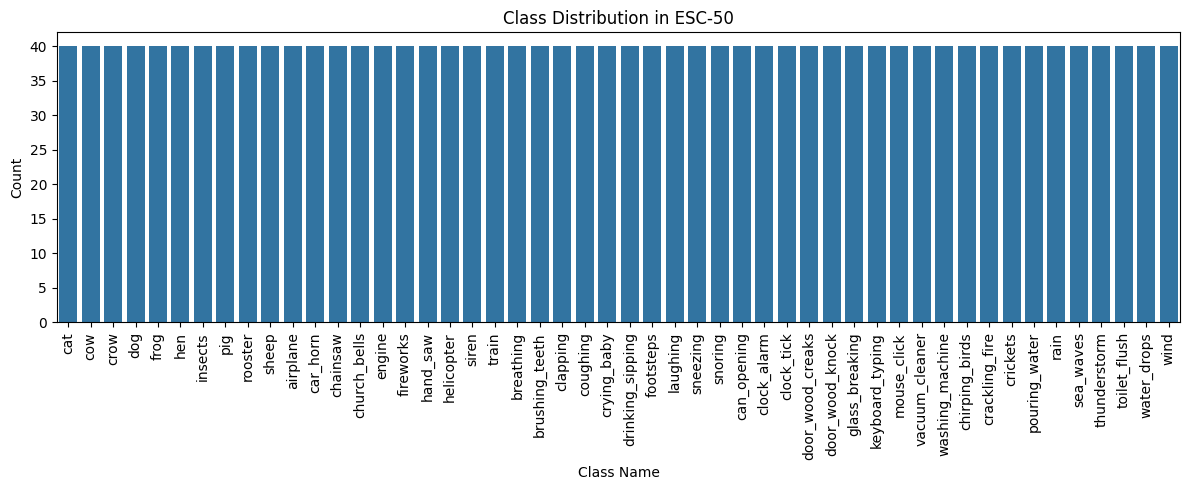


Plotting Major Category Distribution:


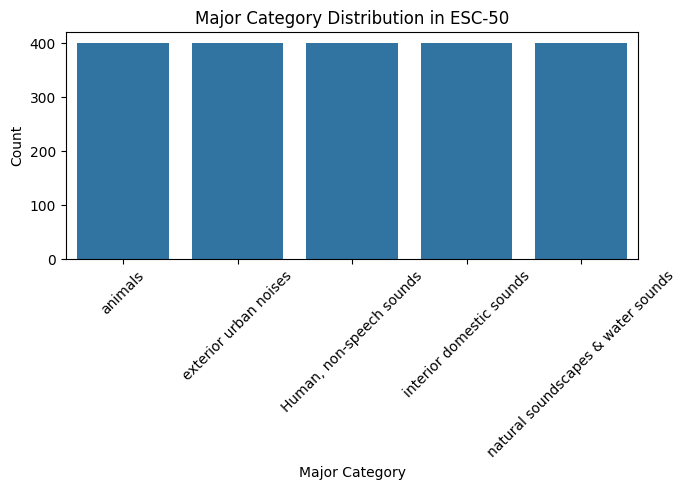


Displaying Audio Waveforms & Spectrograms Of Random Samples:


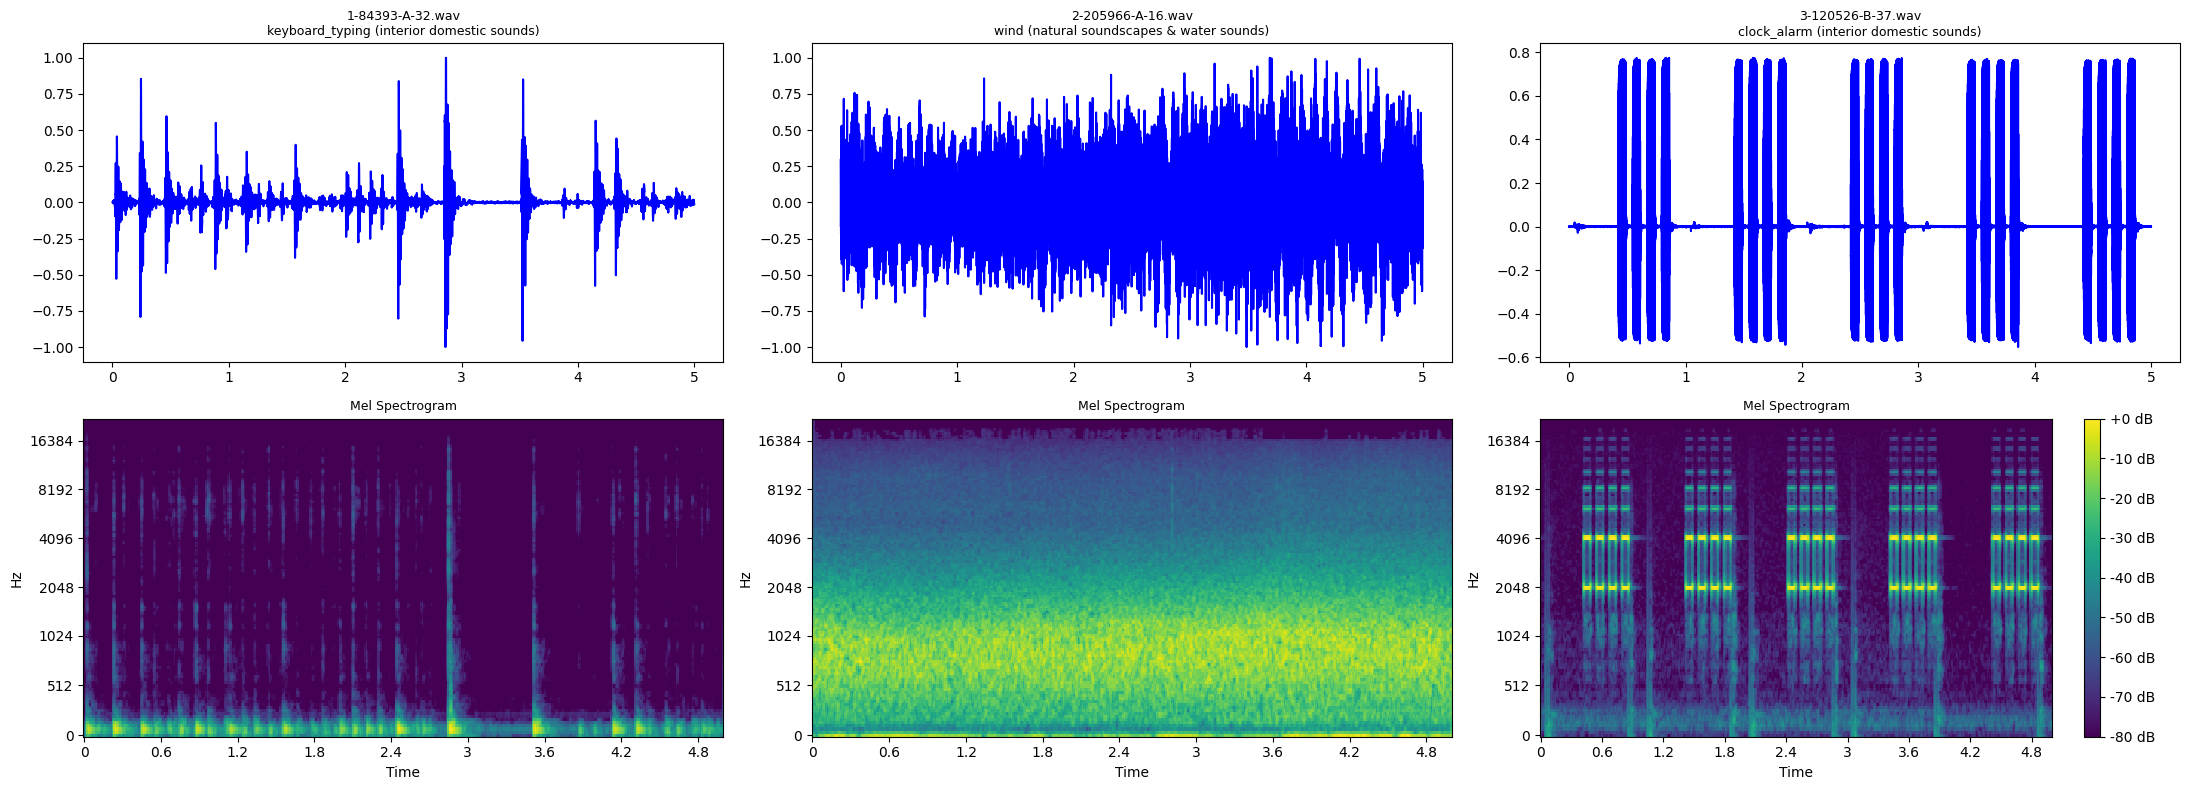


Detected 50 total unique classes: ['airplane', 'breathing', 'brushing_teeth', 'can_opening', 'car_horn', 'cat', 'chainsaw', 'chirping_birds', 'church_bells', 'clapping', 'clock_alarm', 'clock_tick', 'coughing', 'cow', 'crackling_fire', 'crickets', 'crow', 'crying_baby', 'dog', 'door_wood_creaks', 'door_wood_knock', 'drinking_sipping', 'engine', 'fireworks', 'footsteps', 'frog', 'glass_breaking', 'hand_saw', 'helicopter', 'hen', 'insects', 'keyboard_typing', 'laughing', 'mouse_click', 'pig', 'pouring_water', 'rain', 'rooster', 'sea_waves', 'sheep', 'siren', 'sneezing', 'snoring', 'thunderstorm', 'toilet_flush', 'train', 'vacuum_cleaner', 'washing_machine', 'water_drops', 'wind']

=== ReFixMatch with 5 labeled samples per class ===


5_PerClass [Epoch 1/20] TrainLoss: 4.2842 (Sup=4.1010, Unsup=0.2291), TrainAcc: 0.00% | ValLoss: 3.9302, ValAcc: 2.00%


5_PerClass [Epoch 2/20] TrainLoss: 4.3481 (Sup=3.9548, Unsup=0.4916), TrainAcc: 5.20% | ValLoss: 3.9579, ValAcc: 2.00%


5_PerClass [Epoch 3/20] TrainLoss: 5.2830 (Sup=4.4937, Unsup=0.9866), TrainAcc: 2.00% | ValLoss: 4.6617, ValAcc: 2.00%


5_PerClass [Epoch 4/20] TrainLoss: 4.6275 (Sup=3.9189, Unsup=0.8857), TrainAcc: 2.40% | ValLoss: 3.9273, ValAcc: 2.50%


5_PerClass [Epoch 5/20] TrainLoss: 3.9027 (Sup=3.1626, Unsup=0.9251), TrainAcc: 7.60% | ValLoss: 3.2799, ValAcc: 11.00%


5_PerClass [Epoch 6/20] TrainLoss: 3.1927 (Sup=2.3579, Unsup=1.0435), TrainAcc: 22.80% | ValLoss: 2.6531, ValAcc: 27.50%


5_PerClass [Epoch 7/20] TrainLoss: 2.9122 (Sup=1.8388, Unsup=1.3417), TrainAcc: 40.40% | ValLoss: 2.4155, ValAcc: 33.00%


5_PerClass [Epoch 8/20] TrainLoss: 3.0905 (Sup=1.3754, Unsup=2.1439), TrainAcc: 60.80% | ValLoss: 2.7121, ValAcc: 35.50%


5_PerClass [Epoch 9/20] TrainLoss: 2.8943 (Sup=1.4020, Unsup=1.8654), TrainAcc: 56.40% | ValLoss: 2.6073, ValAcc: 37.00%


5_PerClass [Epoch 10/20] TrainLoss: 2.9253 (Sup=1.2547, Unsup=2.0883), TrainAcc: 58.40% | ValLoss: 2.3333, ValAcc: 43.50%


5_PerClass [Epoch 11/20] TrainLoss: 2.5302 (Sup=1.1501, Unsup=1.7252), TrainAcc: 64.80% | ValLoss: 2.0600, ValAcc: 50.50%


5_PerClass [Epoch 12/20] TrainLoss: 2.4051 (Sup=0.9053, Unsup=1.8748), TrainAcc: 69.60% | ValLoss: 2.0330, ValAcc: 48.00%


5_PerClass [Epoch 13/20] TrainLoss: 2.2752 (Sup=0.8460, Unsup=1.7866), TrainAcc: 73.60% | ValLoss: 2.1053, ValAcc: 52.50%


5_PerClass [Epoch 14/20] TrainLoss: 2.1877 (Sup=0.7922, Unsup=1.7444), TrainAcc: 76.00% | ValLoss: 1.9798, ValAcc: 55.00%


5_PerClass [Epoch 15/20] TrainLoss: 1.8458 (Sup=0.6105, Unsup=1.5442), TrainAcc: 80.80% | ValLoss: 1.8408, ValAcc: 56.50%


5_PerClass [Epoch 16/20] TrainLoss: 1.8457 (Sup=0.5637, Unsup=1.6025), TrainAcc: 82.00% | ValLoss: 1.9221, ValAcc: 54.50%


5_PerClass [Epoch 17/20] TrainLoss: 1.8015 (Sup=0.4274, Unsup=1.7176), TrainAcc: 87.20% | ValLoss: 1.9028, ValAcc: 56.00%


5_PerClass [Epoch 18/20] TrainLoss: 1.8180 (Sup=0.4465, Unsup=1.7143), TrainAcc: 88.40% | ValLoss: 1.9365, ValAcc: 55.00%


5_PerClass [Epoch 19/20] TrainLoss: 1.5771 (Sup=0.4480, Unsup=1.4113), TrainAcc: 89.20% | ValLoss: 1.8650, ValAcc: 54.50%


5_PerClass [Epoch 20/20] TrainLoss: 1.8339 (Sup=0.4317, Unsup=1.7528), TrainAcc: 88.40% | ValLoss: 1.9091, ValAcc: 56.00%

5_PerClass --- Final Test Results ---
Test Accuracy: 50.00%
ROC AUC: 0.9568, Average Precision (AUC-PRC): 0.5989

Classification Report:
                  precision    recall  f1-score   support

        airplane       1.00      0.25      0.40         4
       breathing       1.00      0.50      0.67         4
  brushing_teeth       0.40      0.50      0.44         4
     can_opening       0.25      0.75      0.38         4
        car_horn       0.43      0.75      0.55         4
             cat       0.43      0.75      0.55         4
        chainsaw       0.50      0.25      0.33         4
  chirping_birds       1.00      0.75      0.86         4
    church_bells       0.80      1.00      0.89         4
        clapping       0.50      0.25      0.33         4
     clock_alarm       1.00      0.75      0.86         4
      clock_tick       0.50      0.75      

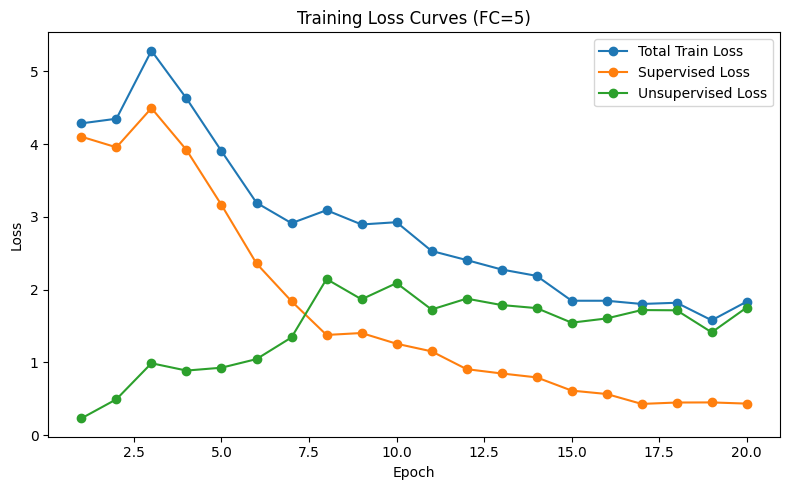

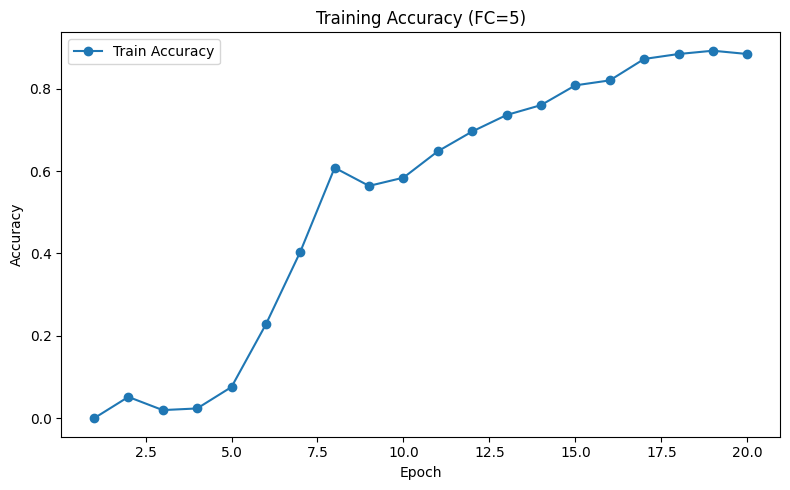

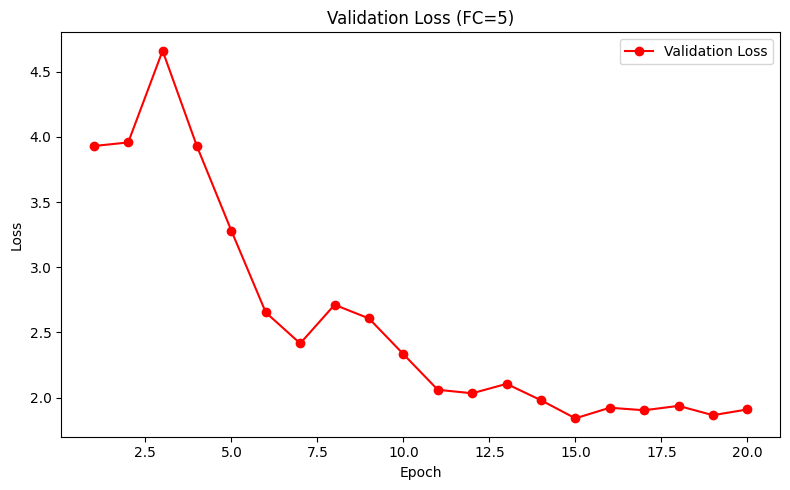

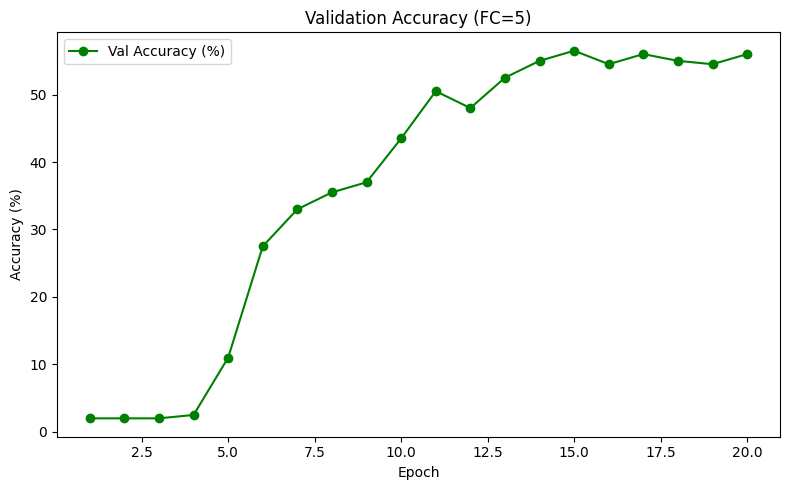

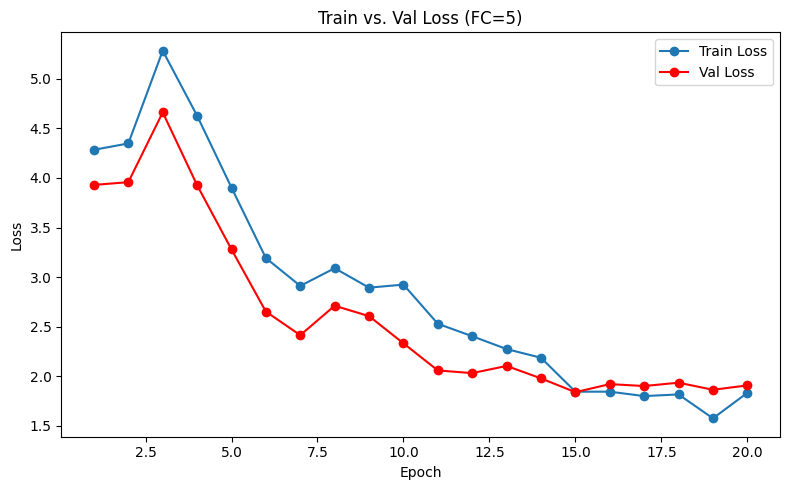

Test Accuracy with 5 labeled/class: 50.00%


=== ReFixMatch with 9 labeled samples per class ===


9_PerClass [Epoch 1/20] TrainLoss: 4.6872 (Sup=4.3022, Unsup=0.4812), TrainAcc: 1.78% | ValLoss: 5.6722, ValAcc: 2.00%


9_PerClass [Epoch 2/20] TrainLoss: 5.3106 (Sup=4.6093, Unsup=0.8766), TrainAcc: 2.22% | ValLoss: 3.8524, ValAcc: 2.00%


9_PerClass [Epoch 3/20] TrainLoss: 4.1434 (Sup=3.1810, Unsup=1.2030), TrainAcc: 12.22% | ValLoss: 2.9679, ValAcc: 24.00%


9_PerClass [Epoch 4/20] TrainLoss: 3.8249 (Sup=2.5032, Unsup=1.6522), TrainAcc: 28.67% | ValLoss: 2.3318, ValAcc: 39.50%


9_PerClass [Epoch 5/20] TrainLoss: 3.6118 (Sup=2.1412, Unsup=1.8382), TrainAcc: 38.44% | ValLoss: 1.9584, ValAcc: 47.00%


9_PerClass [Epoch 6/20] TrainLoss: 3.2467 (Sup=1.8444, Unsup=1.7528), TrainAcc: 45.56% | ValLoss: 2.0990, ValAcc: 42.50%


9_PerClass [Epoch 7/20] TrainLoss: 3.0111 (Sup=1.5399, Unsup=1.8390), TrainAcc: 48.67% | ValLoss: 2.2643, ValAcc: 49.50%


9_PerClass [Epoch 8/20] TrainLoss: 2.7696 (Sup=1.4729, Unsup=1.6208), TrainAcc: 56.22% | ValLoss: 2.0179, ValAcc: 49.50%


9_PerClass [Epoch 9/20] TrainLoss: 2.8130 (Sup=1.4414, Unsup=1.7145), TrainAcc: 58.44% | ValLoss: 1.6620, ValAcc: 55.00%


9_PerClass [Epoch 10/20] TrainLoss: 2.4106 (Sup=1.2533, Unsup=1.4466), TrainAcc: 63.78% | ValLoss: 1.3724, ValAcc: 65.50%


9_PerClass [Epoch 11/20] TrainLoss: 2.3699 (Sup=0.9322, Unsup=1.7971), TrainAcc: 72.22% | ValLoss: 1.5579, ValAcc: 61.50%


9_PerClass [Epoch 12/20] TrainLoss: 2.3550 (Sup=0.8723, Unsup=1.8533), TrainAcc: 74.22% | ValLoss: 1.3174, ValAcc: 63.50%


9_PerClass [Epoch 13/20] TrainLoss: 2.1189 (Sup=0.8234, Unsup=1.6193), TrainAcc: 76.00% | ValLoss: 1.3019, ValAcc: 69.50%


9_PerClass [Epoch 14/20] TrainLoss: 1.9195 (Sup=0.6577, Unsup=1.5772), TrainAcc: 80.00% | ValLoss: 1.2204, ValAcc: 68.00%


9_PerClass [Epoch 15/20] TrainLoss: 1.6848 (Sup=0.5849, Unsup=1.3749), TrainAcc: 83.33% | ValLoss: 1.1720, ValAcc: 68.50%


9_PerClass [Epoch 16/20] TrainLoss: 1.6967 (Sup=0.6026, Unsup=1.3676), TrainAcc: 85.33% | ValLoss: 1.0021, ValAcc: 74.00%


9_PerClass [Epoch 17/20] TrainLoss: 1.6209 (Sup=0.4884, Unsup=1.4157), TrainAcc: 85.78% | ValLoss: 1.1148, ValAcc: 70.50%


9_PerClass [Epoch 18/20] TrainLoss: 1.5592 (Sup=0.5213, Unsup=1.2974), TrainAcc: 88.44% | ValLoss: 1.0360, ValAcc: 70.50%


9_PerClass [Epoch 19/20] TrainLoss: 1.4043 (Sup=0.4208, Unsup=1.2294), TrainAcc: 88.00% | ValLoss: 1.0532, ValAcc: 71.50%


9_PerClass [Epoch 20/20] TrainLoss: 1.4968 (Sup=0.4054, Unsup=1.3643), TrainAcc: 89.33% | ValLoss: 1.0894, ValAcc: 72.00%

9_PerClass --- Final Test Results ---
Test Accuracy: 71.00%
ROC AUC: 0.9821, Average Precision (AUC-PRC): 0.7622

Classification Report:
                  precision    recall  f1-score   support

        airplane       0.75      0.75      0.75         4
       breathing       0.75      0.75      0.75         4
  brushing_teeth       1.00      1.00      1.00         4
     can_opening       0.60      0.75      0.67         4
        car_horn       1.00      1.00      1.00         4
             cat       1.00      1.00      1.00         4
        chainsaw       1.00      0.75      0.86         4
  chirping_birds       0.80      1.00      0.89         4
    church_bells       0.60      0.75      0.67         4
        clapping       1.00      0.25      0.40         4
     clock_alarm       1.00      1.00      1.00         4
      clock_tick       0.80      1.00      

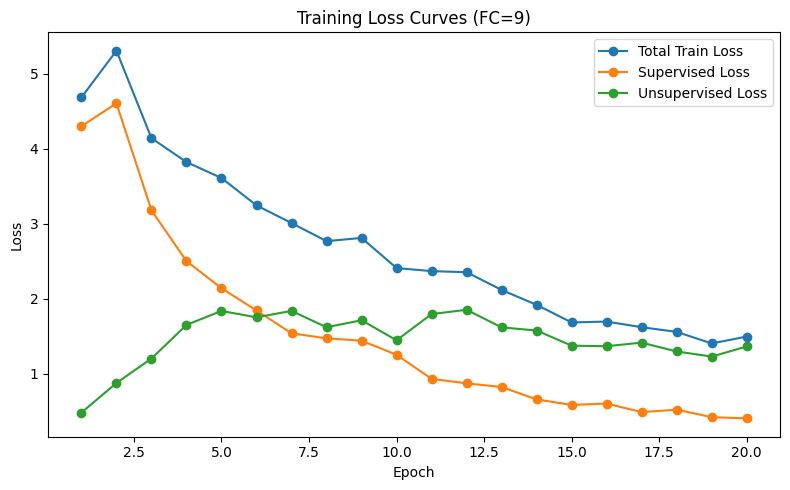

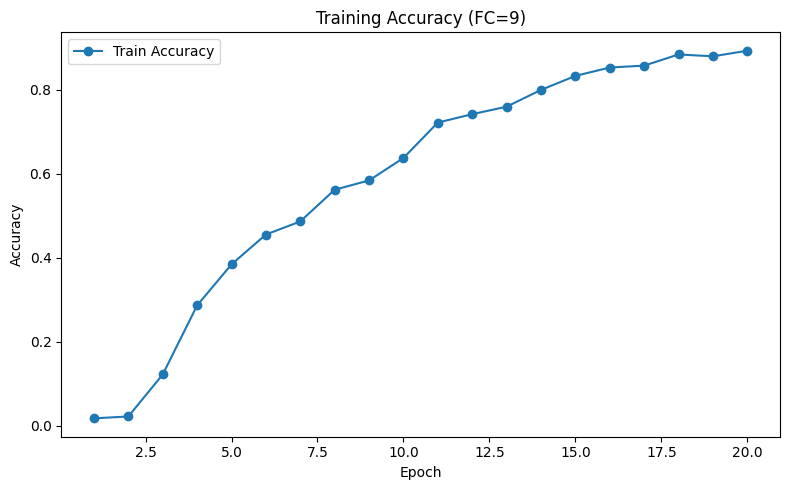

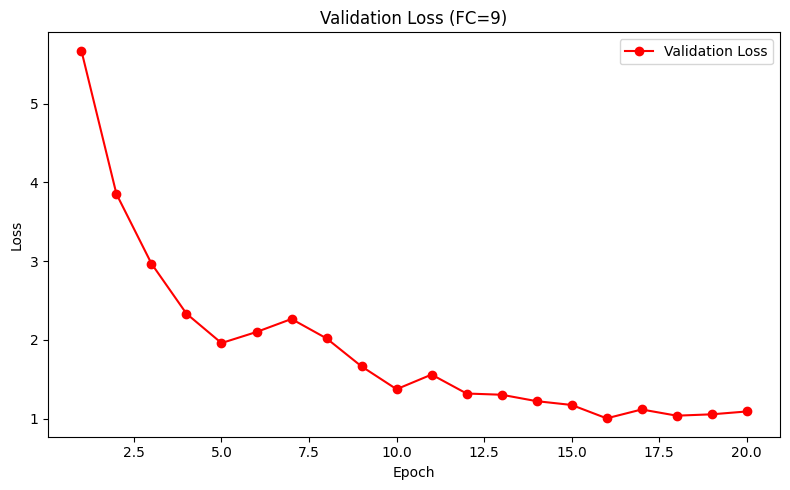

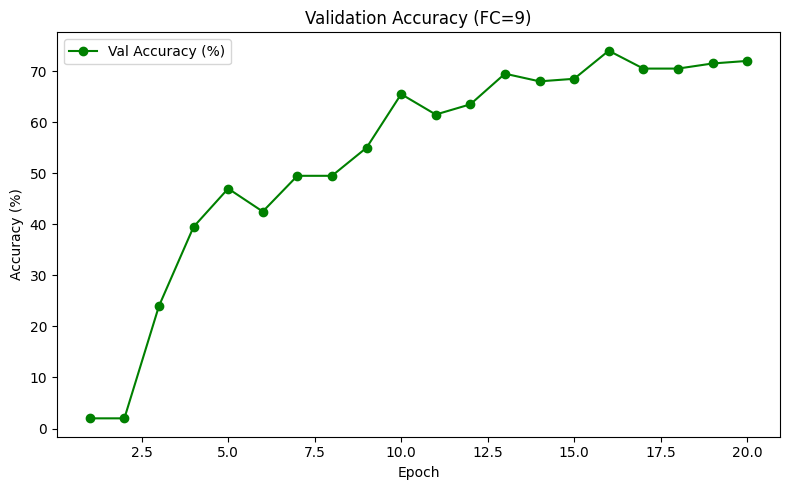

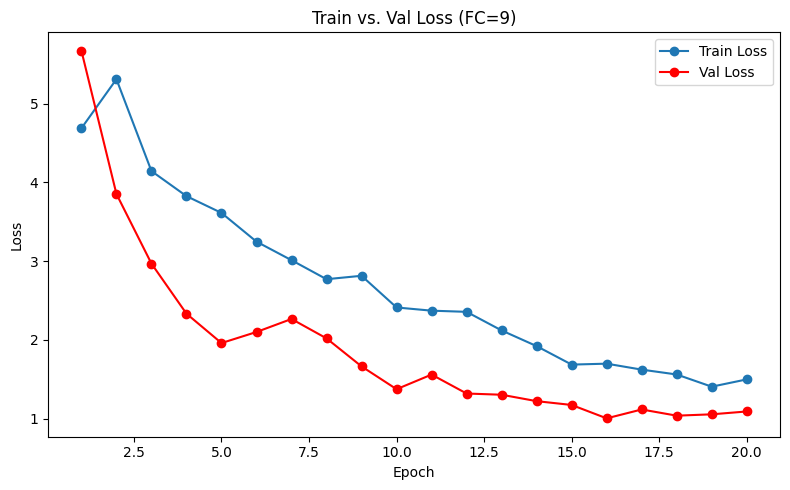

Test Accuracy with 9 labeled/class: 71.00%


=== ReFixMatch with 17 labeled samples per class ===


17_PerClass [Epoch 1/20] TrainLoss: 5.2997 (Sup=4.7030, Unsup=0.7459), TrainAcc: 1.88% | ValLoss: 4.8240, ValAcc: 2.00%


17_PerClass [Epoch 2/20] TrainLoss: 4.3189 (Sup=3.4280, Unsup=1.1136), TrainAcc: 12.00% | ValLoss: 3.1567, ValAcc: 22.00%


17_PerClass [Epoch 3/20] TrainLoss: 3.9748 (Sup=2.5797, Unsup=1.7439), TrainAcc: 30.00% | ValLoss: 2.3678, ValAcc: 37.00%


17_PerClass [Epoch 4/20] TrainLoss: 3.5146 (Sup=2.1439, Unsup=1.7135), TrainAcc: 40.59% | ValLoss: 2.3684, ValAcc: 40.00%


17_PerClass [Epoch 5/20] TrainLoss: 2.9765 (Sup=1.6983, Unsup=1.5978), TrainAcc: 49.76% | ValLoss: 1.6087, ValAcc: 54.50%


17_PerClass [Epoch 6/20] TrainLoss: 2.8756 (Sup=1.5642, Unsup=1.6393), TrainAcc: 55.18% | ValLoss: 2.7677, ValAcc: 39.00%


17_PerClass [Epoch 7/20] TrainLoss: 2.6245 (Sup=1.3929, Unsup=1.5395), TrainAcc: 58.00% | ValLoss: 1.5499, ValAcc: 60.50%


17_PerClass [Epoch 8/20] TrainLoss: 2.4202 (Sup=1.1259, Unsup=1.6178), TrainAcc: 66.35% | ValLoss: 1.2041, ValAcc: 65.00%


17_PerClass [Epoch 9/20] TrainLoss: 2.2263 (Sup=0.9761, Unsup=1.5628), TrainAcc: 69.53% | ValLoss: 1.3683, ValAcc: 66.50%


17_PerClass [Epoch 10/20] TrainLoss: 1.9259 (Sup=0.9156, Unsup=1.2629), TrainAcc: 71.88% | ValLoss: 1.2749, ValAcc: 63.50%


17_PerClass [Epoch 11/20] TrainLoss: 1.8006 (Sup=0.7504, Unsup=1.3127), TrainAcc: 77.53% | ValLoss: 1.3509, ValAcc: 68.50%


17_PerClass [Epoch 12/20] TrainLoss: 1.7129 (Sup=0.5627, Unsup=1.4378), TrainAcc: 83.41% | ValLoss: 1.5203, ValAcc: 62.50%


17_PerClass [Epoch 13/20] TrainLoss: 1.5917 (Sup=0.6211, Unsup=1.2133), TrainAcc: 82.82% | ValLoss: 0.9520, ValAcc: 74.00%


17_PerClass [Epoch 14/20] TrainLoss: 1.3277 (Sup=0.4410, Unsup=1.1083), TrainAcc: 87.29% | ValLoss: 0.8731, ValAcc: 76.50%


17_PerClass [Epoch 15/20] TrainLoss: 1.2661 (Sup=0.3426, Unsup=1.1543), TrainAcc: 90.00% | ValLoss: 0.9307, ValAcc: 77.00%


17_PerClass [Epoch 16/20] TrainLoss: 1.2373 (Sup=0.3703, Unsup=1.0838), TrainAcc: 88.59% | ValLoss: 0.8639, ValAcc: 76.00%


17_PerClass [Epoch 17/20] TrainLoss: 1.0281 (Sup=0.3341, Unsup=0.8675), TrainAcc: 91.41% | ValLoss: 0.7372, ValAcc: 78.00%


17_PerClass [Epoch 18/20] TrainLoss: 0.9376 (Sup=0.2632, Unsup=0.8430), TrainAcc: 93.06% | ValLoss: 0.7477, ValAcc: 77.50%


17_PerClass [Epoch 19/20] TrainLoss: 0.9949 (Sup=0.2442, Unsup=0.9383), TrainAcc: 93.65% | ValLoss: 0.8691, ValAcc: 75.50%


17_PerClass [Epoch 20/20] TrainLoss: 0.9868 (Sup=0.2685, Unsup=0.8978), TrainAcc: 91.06% | ValLoss: 0.6960, ValAcc: 79.00%

17_PerClass --- Final Test Results ---
Test Accuracy: 80.00%
ROC AUC: 0.9939, Average Precision (AUC-PRC): 0.8919

Classification Report:
                  precision    recall  f1-score   support

        airplane       0.43      0.75      0.55         4
       breathing       0.75      0.75      0.75         4
  brushing_teeth       0.80      1.00      0.89         4
     can_opening       1.00      0.75      0.86         4
        car_horn       1.00      1.00      1.00         4
             cat       1.00      1.00      1.00         4
        chainsaw       1.00      0.75      0.86         4
  chirping_birds       1.00      1.00      1.00         4
    church_bells       1.00      1.00      1.00         4
        clapping       0.80      1.00      0.89         4
     clock_alarm       1.00      1.00      1.00         4
      clock_tick       1.00      1.00    

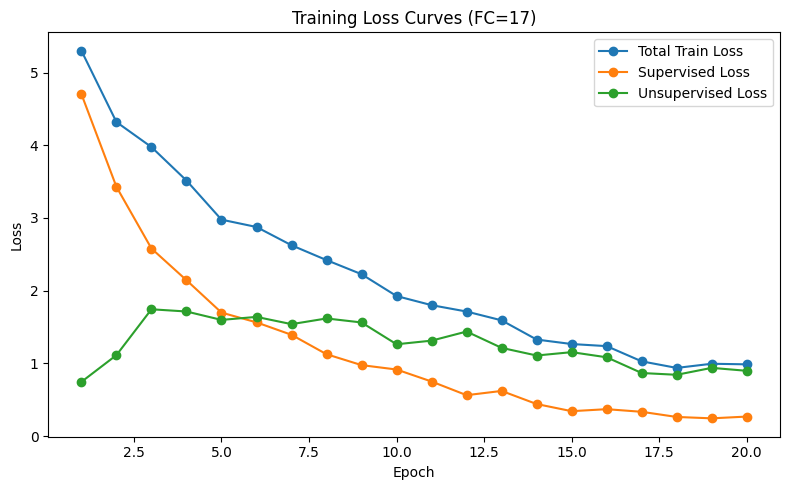

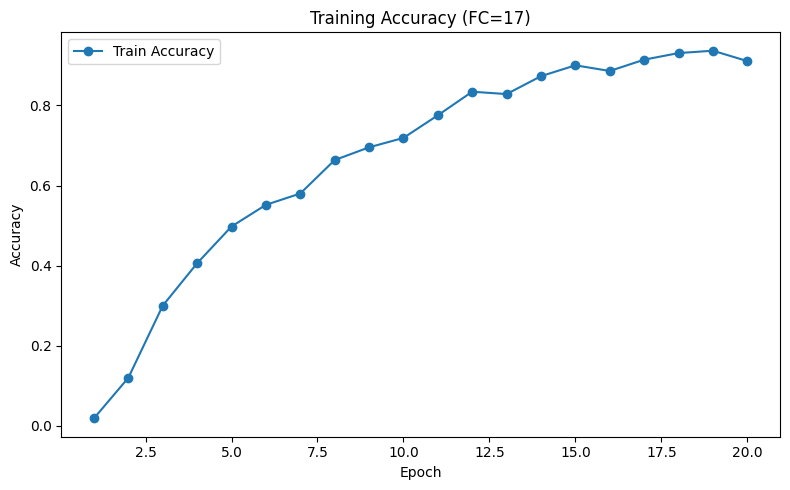

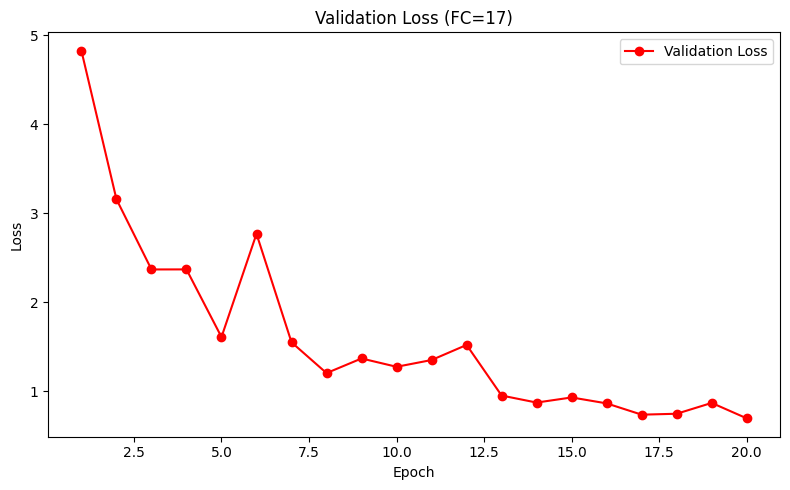

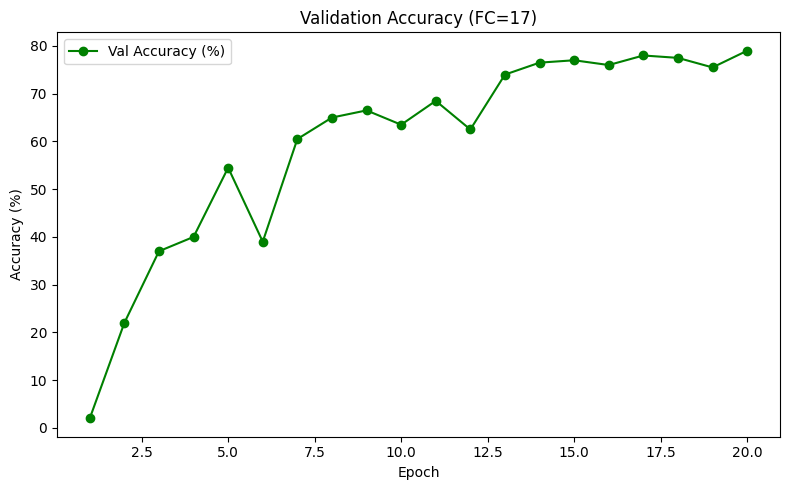

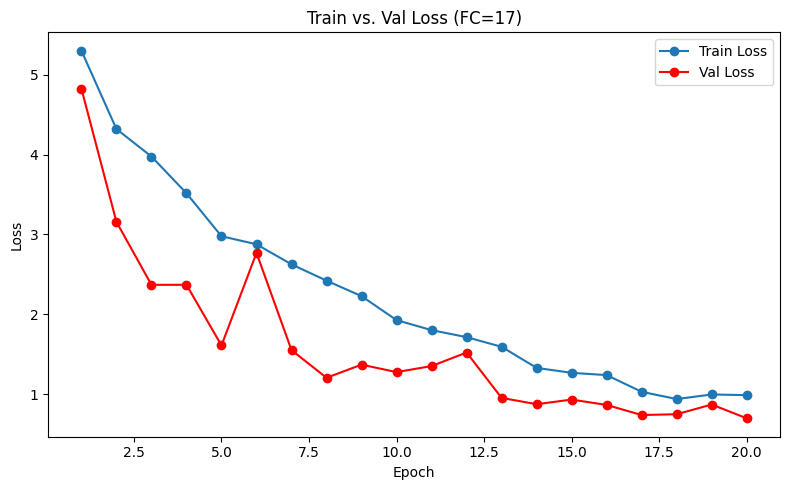

Test Accuracy with 17 labeled/class: 80.00%


=== ReFixMatch with 26 labeled samples per class ===


26_PerClass [Epoch 1/20] TrainLoss: 4.8164 (Sup=4.2643, Unsup=0.6902), TrainAcc: 2.54% | ValLoss: 2.8660, ValAcc: 12.50%


26_PerClass [Epoch 2/20] TrainLoss: 4.1312 (Sup=2.8028, Unsup=1.6606), TrainAcc: 23.62% | ValLoss: 2.4869, ValAcc: 34.50%


26_PerClass [Epoch 3/20] TrainLoss: 3.5548 (Sup=2.1677, Unsup=1.7339), TrainAcc: 38.15% | ValLoss: 1.7874, ValAcc: 50.50%


26_PerClass [Epoch 4/20] TrainLoss: 3.1788 (Sup=1.7950, Unsup=1.7297), TrainAcc: 48.77% | ValLoss: 1.4290, ValAcc: 59.50%


26_PerClass [Epoch 5/20] TrainLoss: 2.6894 (Sup=1.5541, Unsup=1.4190), TrainAcc: 56.38% | ValLoss: 1.5920, ValAcc: 61.00%


26_PerClass [Epoch 6/20] TrainLoss: 2.4019 (Sup=1.2243, Unsup=1.4720), TrainAcc: 62.77% | ValLoss: 1.4893, ValAcc: 64.00%


26_PerClass [Epoch 7/20] TrainLoss: 2.0547 (Sup=1.0647, Unsup=1.2376), TrainAcc: 69.38% | ValLoss: 1.1773, ValAcc: 67.00%


26_PerClass [Epoch 8/20] TrainLoss: 1.8819 (Sup=0.8836, Unsup=1.2479), TrainAcc: 71.62% | ValLoss: 0.9446, ValAcc: 77.00%


26_PerClass [Epoch 9/20] TrainLoss: 1.5084 (Sup=0.7006, Unsup=1.0097), TrainAcc: 77.85% | ValLoss: 1.0504, ValAcc: 73.00%


26_PerClass [Epoch 10/20] TrainLoss: 1.4347 (Sup=0.6046, Unsup=1.0376), TrainAcc: 81.00% | ValLoss: 0.9995, ValAcc: 74.00%


26_PerClass [Epoch 11/20] TrainLoss: 1.2273 (Sup=0.4999, Unsup=0.9092), TrainAcc: 84.62% | ValLoss: 1.0013, ValAcc: 77.00%


26_PerClass [Epoch 12/20] TrainLoss: 1.0479 (Sup=0.4266, Unsup=0.7767), TrainAcc: 85.54% | ValLoss: 0.8258, ValAcc: 78.50%


26_PerClass [Epoch 13/20] TrainLoss: 0.8362 (Sup=0.3647, Unsup=0.5894), TrainAcc: 88.54% | ValLoss: 0.7182, ValAcc: 80.50%


26_PerClass [Epoch 14/20] TrainLoss: 0.6864 (Sup=0.2852, Unsup=0.5014), TrainAcc: 90.08% | ValLoss: 0.9113, ValAcc: 78.00%


26_PerClass [Epoch 15/20] TrainLoss: 0.6422 (Sup=0.2614, Unsup=0.4760), TrainAcc: 91.62% | ValLoss: 0.7678, ValAcc: 78.50%


26_PerClass [Epoch 16/20] TrainLoss: 0.5088 (Sup=0.1916, Unsup=0.3964), TrainAcc: 94.23% | ValLoss: 0.5442, ValAcc: 81.50%


26_PerClass [Epoch 17/20] TrainLoss: 0.4528 (Sup=0.1528, Unsup=0.3751), TrainAcc: 95.46% | ValLoss: 0.5924, ValAcc: 82.50%


26_PerClass [Epoch 18/20] TrainLoss: 0.3811 (Sup=0.1219, Unsup=0.3240), TrainAcc: 96.46% | ValLoss: 0.6656, ValAcc: 81.50%


26_PerClass [Epoch 19/20] TrainLoss: 0.3161 (Sup=0.1152, Unsup=0.2511), TrainAcc: 97.38% | ValLoss: 0.6766, ValAcc: 81.50%


26_PerClass [Epoch 20/20] TrainLoss: 0.3662 (Sup=0.1261, Unsup=0.3001), TrainAcc: 96.85% | ValLoss: 0.6292, ValAcc: 82.00%

26_PerClass --- Final Test Results ---
Test Accuracy: 85.50%
ROC AUC: 0.9951, Average Precision (AUC-PRC): 0.9127

Classification Report:
                  precision    recall  f1-score   support

        airplane       0.75      0.75      0.75         4
       breathing       1.00      0.75      0.86         4
  brushing_teeth       0.75      0.75      0.75         4
     can_opening       1.00      1.00      1.00         4
        car_horn       1.00      1.00      1.00         4
             cat       1.00      1.00      1.00         4
        chainsaw       1.00      0.75      0.86         4
  chirping_birds       1.00      1.00      1.00         4
    church_bells       0.80      1.00      0.89         4
        clapping       1.00      0.75      0.86         4
     clock_alarm       1.00      1.00      1.00         4
      clock_tick       1.00      1.00    

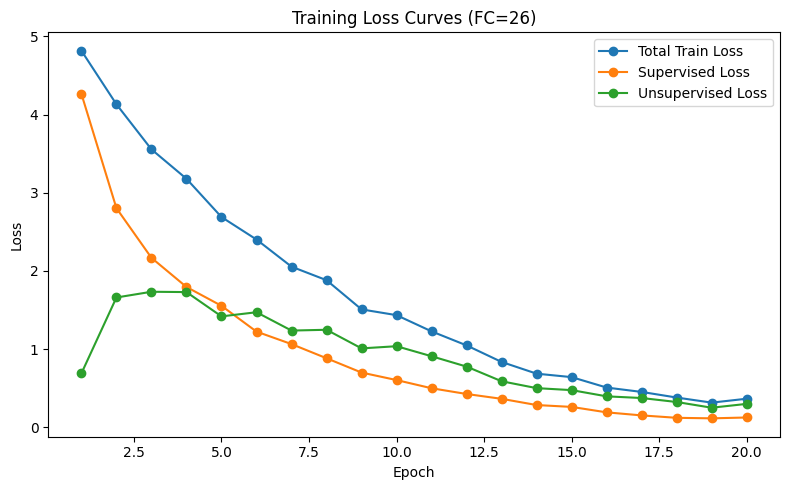

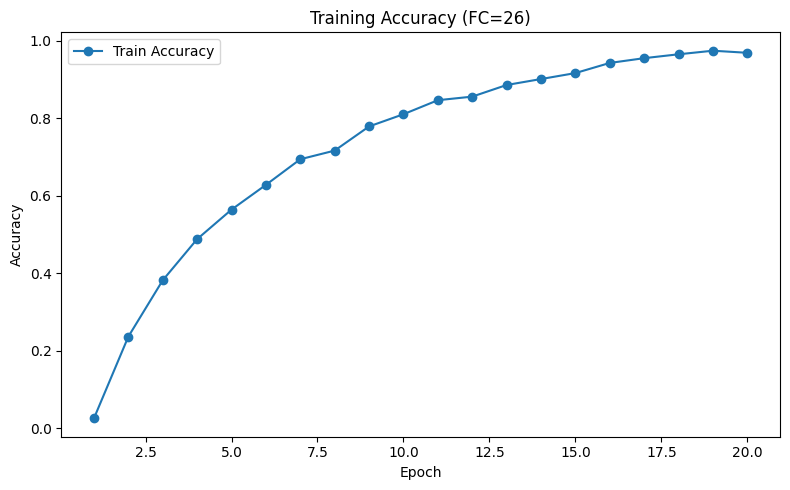

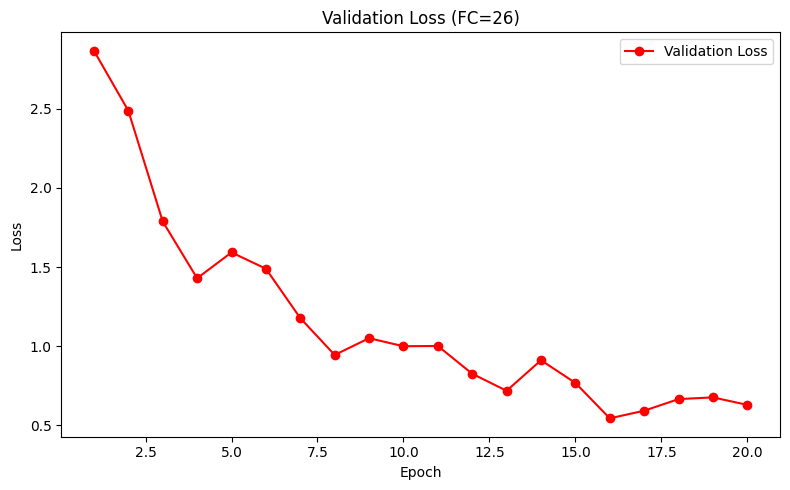

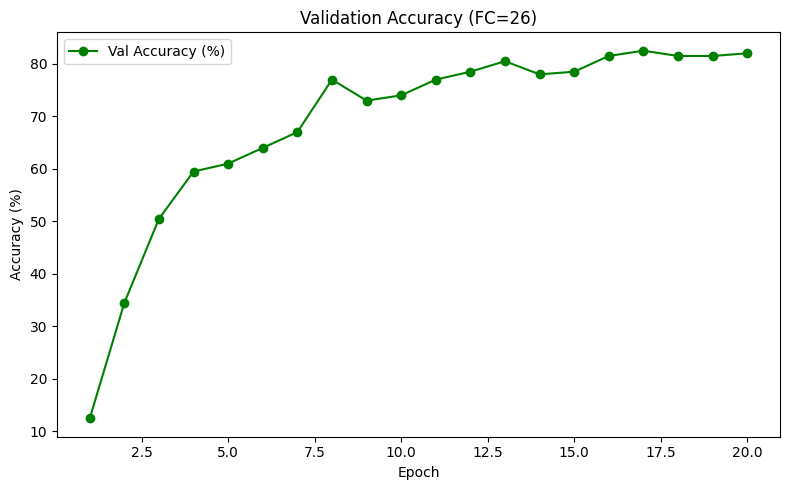

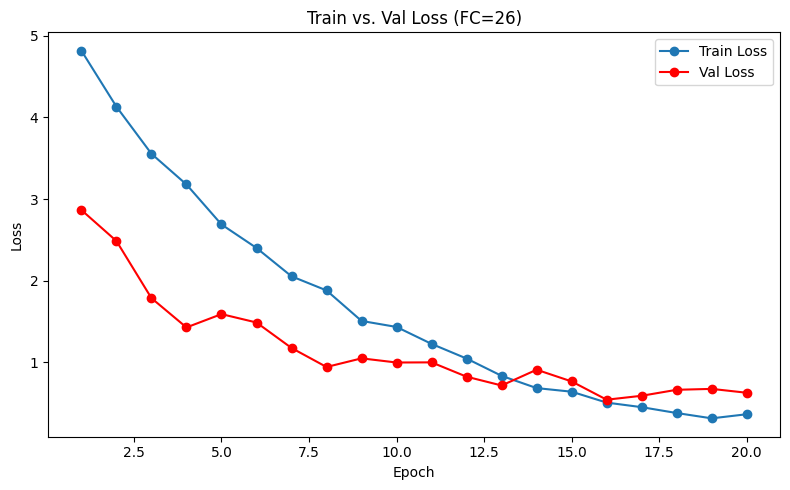

Test Accuracy with 26 labeled/class: 85.50%


========== SUMMARY OF ALL RUNS ==========
 Labeled/Class = 5: TestAcc = 50.00%, LastValAcc = 56.00%
 Labeled/Class = 9: TestAcc = 71.00%, LastValAcc = 72.00%
 Labeled/Class = 17: TestAcc = 80.00%, LastValAcc = 79.00%
 Labeled/Class = 26: TestAcc = 85.50%, LastValAcc = 82.00%


In [ ]:
if __name__ == "__main__":
    from multiprocessing import freeze_support
    freeze_support()
    Main()